In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys

import numpy as np

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache

import matplotlib.pyplot as plt

## Generate and download HSC cutout images

* For most scientific applications, the coadd image will be the most useful one. And HSC archive provides ways to generate and download cutout coadd images around a desired location.  The best-fit PSF model at that location can be downloaded too.  

* Please see this [manual](https://hsc-release.mtk.nao.ac.jp/das_quarry/manual.html) for details about using the on-line cutout server; and see [here](https://hsc-release.mtk.nao.ac.jp/psf/pdr1/manual.html) for details about using the PSF Picker.

* Basic of HSC coadd images: 
    - Pixel scale: 0.168"/pix
    - Zeropoint: 27.0 mag in all 5-band
    - Maximum size of the cutout is 3 `Patches`, so about 35 arcmin.
    
### Step 1: Setup HSC-SSP online data archive 

* First, you need to setup a HSC-SSP rerun
* Here we use the ultra-deep field from the `PDR2` as an example

In [5]:
from unagi import config
from unagi import hsc
from unagi import plotting
from unagi.task import hsc_cutout

pdr2 = hsc.Hsc(dr='pdr2', rerun='pdr2_wide')

# Get table list from /Users/cbottrell/Project/HSC-Subaru/unagi/unagi/data/pdr2_wide/pdr2_wide_tables.fits


### Step 2: Design the cutout region

* There are two ways to design a cutout region:

1. Using the central coordinate and the size of the cutout region:
    * **Central coordinate** should be a `SkyCoord` object in `astropy`
    * **Size of the image** should be a `Quantity` object in `astropy`. It should have a **unit**, either angular or physical one is fine
        - For angular size: `u.arcsec` is default. 
        - For physical size: `u.kpc` is default, and you need to provide the `redshift` of the object. 
        - To convert physical size into pixel unit, we also need to assume cosmology. You can define cosmology model using the `cosmology` module in `astropy` and pass it to the code using `cosmo` option.  Default one assumes `H0=70.` and `Om=0.3` `LambdaCDMFlat` cosmology
2. Using the coordinates of the diagnoal corners.
    * Both **corner coordinates** should be `SkyCoord` objects.

* **Filters** used to generate the picture. Default is `i`
    - Formal format like `HSC-G` also works. 
    - A list of filters also works, like `gri`, or `[HSG-G, HSC-R]`.
    
* **Image type**:
    - `coadd`: Download the cutout of the coadd image. 
    - `warped`: Download the warped individual exposures that contribute to the cutout region. The output file is a `.tar` compressed file. 
    
* **Contents**:
    - `image`, `mask`, and `variance`.
    - "A FITS file cut out consists of 4 hdu's (header-data units, or layers): The primary hdu (0th hdu) does not contain any data. The 1st hdu is the image layer, the 2nd hdu is the mask layer, and the 3rd the variance layer."
    - Please note that "these hdu positions are immobile!"

In [3]:
coord_1 = SkyCoord(30.536081, 2.205916, frame='icrs', unit='deg')
coord_2 = SkyCoord(150.1213, 2.235916, frame='icrs', unit='deg')

# Angular size
s_ang = 10.0 * u.arcsec

# Physical size
s_phy = 100.0 * u.kpc
redshift = 0.25

# Filters
filters = 'gri'

# Output dir
output_dir = 'data/'

#### For single-band, you can generate the URL of the cutout image using `form_cutout_url()` function

In [4]:
pdr2.form_cutout_url(coord_1, coord_2=coord_2)

'https://hsc-release.mtk.nao.ac.jp/das_cutout/pdr2/cgi-bin/cutout?ra1=150.091&dec1=2.20592&ra2=150.121&dec2=2.23592&type=coadd&image=on&mask=off&variance=off&filter=HSC-I&rerun=pdr2_dud'

### Running the `hsc_cutout()` task

In [27]:
# Output dir
output_dir = 'Input/'

s_ang = 43.008/2 

# Default 20"x20" cutout around a central coordinate in i-band, just get the image
coord_1 = SkyCoord(30.536081, -6.821022, frame='icrs', unit='deg')

help(pdr2.form_cutout_url)
print(pdr2.form_cutout_url(coord_1, filters=['g','r','i','z','y'],  
                          prefix='filename'))
 

# cutout_test = hsc_cutout(coord_1, cutout_size=s_ang, filters='grizy', archive=pdr2, 
#                          use_saved=False, output_dir=output_dir, verbose=True, 
#                          save_output=True)

cutout_multi = hsc_cutout(coord_1, cutout_size=s_ang, filters='grizy', archive=pdr2, 
                          use_saved=False, output_dir=output_dir, variance=0, mask=0, 
                          prefix='filename')

#w = wcs.WCS(cutout_test[1].header)

#_ = plotting.display_single(cutout_test[1].data)

#cutout_test.close()

Help on method form_cutout_url in module unagi.hsc:

form_cutout_url(coord, coord_2=None, w_half=None, h_half=None, **kwargs) method of unagi.hsc.Hsc instance
    Form the URL to download HSC cutout images.
    
    Please see details here:
        https://hscdata.mtk.nao.ac.jp/das_quarry/dr2.1/manual.html
    
    Example:
        1. Using the (RA, Dec) of the two diagonal corners.
        https://hscdata.mtk.nao.ac.jp/das_quarry/dr2.1/cgi-bin/cutout?ra1=135.0&dec1=0.0&ra2=135.1&dec2=0.1&type=coadd&image=on&filter=HSC-I&tract=9560&rerun=s18a_wide
    
        2. Uisng the (RA, Dec) of the center and the width/height of the image.
        https://hscdata.mtk.nao.ac.jp/das_quarry/dr2.1/cgi-bin/cutout?ra=135.0&dec=0.0&sw=20arcsec&sh=20arcsec&type=coadd&image=on&filter=HSC-I&tract=&rerun=s18a_wide
    
    About the image type:
        1. `coadd`: will return a FITS image.
        2. `warp`: will return a `.tar` compressed file that containts all the warpped images.
    
    Limitation:
 

TypeError: _parse_cutout_center() got an unexpected keyword argument 'filters'

# Retrieving cutout image in filter: i


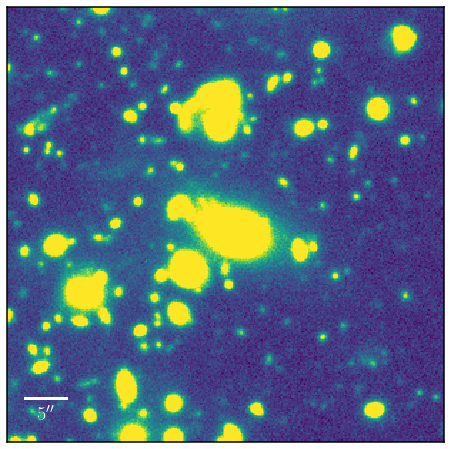

In [16]:
# Using the physical size
# Assuming z=0.25, and we want to get a 200x200 kpc cutout

cutout_phy = hsc_cutout(coord_1, cutout_size=s_phy, redshift=redshift, filters='i', 
                        archive=pdr2, use_saved=False, output_dir=output_dir, verbose=True, 
                        save_output=True)

_ = plotting.display_single(cutout_phy[1].data)

cutout_phy.close()

# Will dgenerate cutouts for a list of filters: ['g', 'i']
# Retrieving cutout image in filter: g
# Retrieving cutout image in filter: i


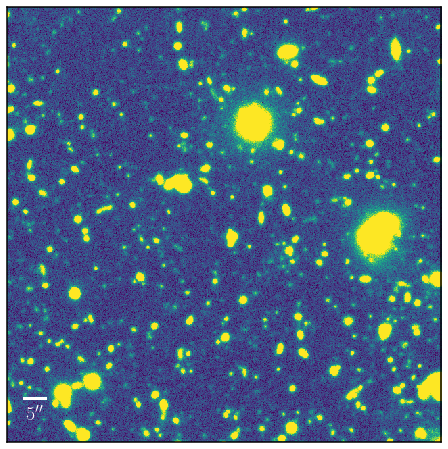

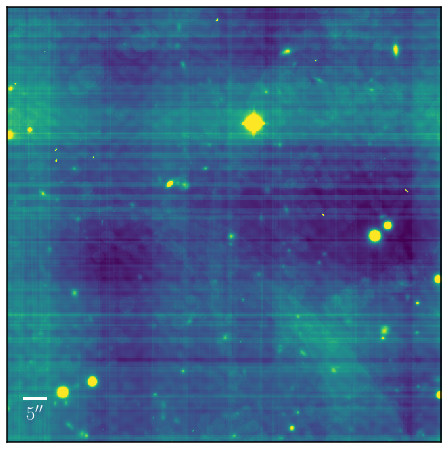

In [17]:
# Using the coordinates of two diagnoal corners
# Also get the mask and variance plane
# In both g- and i-band
# Save the FITS file with the prefix: "awesome_galaxy"

cutout_multi = hsc_cutout(coord_1, coord_2=coord_2, filters='gi', archive=pdr2, 
                          output_dir=output_dir, variance=True, mask=True, 
                          prefix='awesome_galaxy')

# g-band image
_ = plotting.display_single(cutout_multi[0][1].data)

# i-band variance plane
_ = plotting.display_single(cutout_multi[1][3].data)

In [18]:
# Download the tarball of the warped single exposure images in r-band

warped_url = hsc_cutout(coord_2, cutout_size=s_ang, filters='r', img_type='warp', 
                        archive=pdr2, use_saved=False, output_dir=output_dir)

# Retrieving warped images in filter: r


#### Demo Figure

# Get table list from /Users/jiaxuanli/Research/Packages/unagi/unagi/data/pdr2_dud/pdr2_dud_tables.fits
# Retrieving cutout image in filter: i


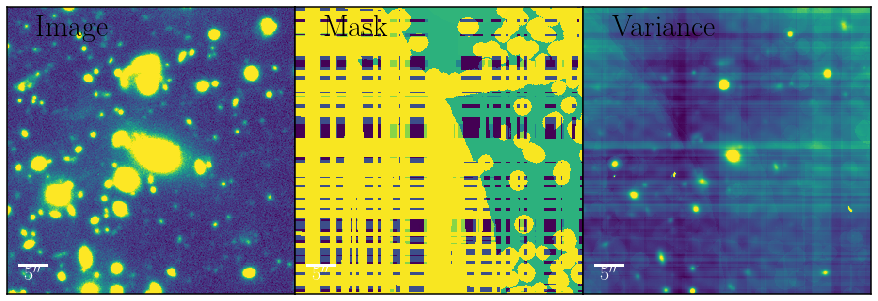

In [23]:
pdr2 = hsc.Hsc(dr='pdr2', rerun='pdr2_dud')

# Using the physical size
# Assuming z=0.25, and we want to get a 200x200 kpc cutout
coord = SkyCoord(150.0913, 2.205916, frame='icrs', unit='deg')
s_phy = 100.0 * u.kpc
redshift = 0.25

cutout_test = hsc_cutout(coord, cutout_size=s_phy, redshift=redshift, filters='i', 
                         archive=pdr2, use_saved=False, output_dir='data/', verbose=True, 
                         save_output=True, image=True, mask=True, variance=True)

label_list = [r"$\rm {}$".format(label) for label in ['Image', 'Mask', 'Variance']]
_ = plotting.display_all(
    cutout_test, hdu_list=True, img_size=4, label_list=label_list, fontsize=30, fontcolor='k')

In [8]:
import os,sys
import numpy as np
import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.utils.data import download_file, clear_download_cache
from unagi import config
from unagi import hsc
from unagi import plotting
from unagi.task import hsc_cutout

pdr2 = hsc.Hsc(dr='pdr2', rerun='pdr2_wide')

cutout_width = 512 # pixels
arcsec_per_pixel = 0.168 # arcsec/pixel
s_ang = cutout_width / 2 * arcsec_per_pixel * u.arcsec # arcsec

# Catalogue
catalogue = '/Users/cbottrell/Project/HSC-Subaru/Catalogues/hsc_tfmorphologies-20190715.txt'
# Output dir
output_dir = 'Input/' 

cat_data = np.loadtxt(catalogue,delimiter=',',dtype='str')
objIDs = cat_data[:,0].astype()
ras = cat_data[:,2].astype(float)
decs = cat_data[:,3].astype(float)
zs = cat_data[:,-1].astype(float)

for objID,ra,dec,z in zip(objIDs,ras,decs,zs):

    # Default 
    coord = SkyCoord(ra, dec, frame='icrs', unit='deg')
    # Make cutouts
    cutout_multi = hsc_cutout(coord, cutout_size=s_ang, filters='grizy', archive=pdr2, 
                              use_saved=False, output_dir=output_dir, variance=1, mask=1, 
                              prefix='{}_Cutout-{}x{}'.format(objID,cutout_width,cutout_width))

# Get table list from /Users/cbottrell/anaconda3/envs/hsc/lib/python3.7/site-packages/unagi-0.1.0-py3.7.egg/unagi/data/pdr2_wide/pdr2_wide_tables.fits
# Will dgenerate cutouts for a list of filters: ['g', 'r', 'i', 'z', 'y']
# Retrieving cutout image in filter: g
# Retrieving cutout image in filter: r
# Retrieving cutout image in filter: i
# Retrieving cutout image in filter: z
# Retrieving cutout image in filter: y
# Will dgenerate cutouts for a list of filters: ['g', 'r', 'i', 'z', 'y']
# Retrieving cutout image in filter: g
# Retrieving cutout image in filter: r
# Retrieving cutout image in filter: i
# Retrieving cutout image in filter: z
# Retrieving cutout image in filter: y
# Will dgenerate cutouts for a list of filters: ['g', 'r', 'i', 'z', 'y']
# Retrieving cutout image in filter: g
# Retrieving cutout image in filter: r
# Retrieving cutout image in filter: i
# Retrieving cutout image in filter: z
# Retrieving cutout image in filter: y
# Will dgenerate cutouts for a list of fil

KeyboardInterrupt: 

In [10]:
import os,sys,time
import numpy as np
import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.utils.data import download_file, clear_download_cache
from unagi import config
from unagi import hsc
from unagi import plotting
from unagi.task import hsc_cutout

pdr2 = hsc.Hsc(dr='pdr2', rerun='pdr2_wide')

cutout_width = 525 # pixels
arcsec_per_pixel = 0.168 # arcsec/pixel
s_ang = cutout_width / 2 * arcsec_per_pixel * u.arcsec # arcsec

# Catalogue
catalogue = '/Users/cbottrell/Project/HSC-Subaru/Catalogues/HSC-TF_all_2019-07-16.txt'
output_dir = '/Volumes/Project_Data/HSC_Subaru/Input/' 
# filename prefix
prefix = '{}_Cutout-{}x{}'

cat_data = np.loadtxt(catalogue,delimiter=',',dtype='str')
objIDs = cat_data[:,0].astype(int)
ras = cat_data[:,2].astype(float)
decs = cat_data[:,3].astype(float)
zs = cat_data[:,1].astype(float)

filterIDs = ['g','r','i','z','y']

for objID,ra,dec,z in zip(objIDs,ras,decs,zs):
    
    # check if y-band image exists (last in list), if true, continue
    fileLast = output_dir+prefix.format(objID,cutout_width,cutout_width)+'_{}.fits'.format(filterIDs[-1])
    if os.access(fileLast,0): continue
    
    # start with no filters
    filters = ''

    # only make images in filters for which images do not already exist
    for filterID in filterIDs:
        fileName = output_dir+prefix.format(objID,cutout_width,cutout_width)+'_{}.fits'.format(filterID)
        if not os.access(fileName,0): filters+=filterID
        
    # coordinate generator
    coord = SkyCoord(ra, dec, frame='icrs', unit='deg')
    
    # make cutouts
    try:
        cutout_multi = hsc_cutout(coord, cutout_size=s_ang, filters=filters, archive=pdr2, 
                                  use_saved=False, output_dir=output_dir, variance=0, mask=0, 
                                  prefix=prefix.format(objID,cutout_width,cutout_width))
        
    # sleep a bit if this doesn't work, and retry
    except:
        time.sleep(120)
        cutout_multi = hsc_cutout(coord, cutout_size=s_ang, filters=filters, archive=pdr2, 
                                  use_saved=False, output_dir=output_dir, variance=0, mask=0, 
                                  prefix=prefix.format(objID,cutout_width,cutout_width))


# Get table list from /Users/cbottrell/anaconda3/envs/hsc/lib/python3.7/site-packages/unagi-0.1.0-py3.7.egg/unagi/data/pdr2_wide/pdr2_wide_tables.fits
# Will dgenerate cutouts for a list of filters: ['g', 'r', 'i', 'z', 'y']
# Retrieving cutout image in filter: g
# Retrieving cutout image in filter: r
# Retrieving cutout image in filter: i
# Retrieving cutout image in filter: z
# Retrieving cutout image in filter: y
# Will dgenerate cutouts for a list of filters: ['g', 'r', 'i', 'z', 'y']
# Retrieving cutout image in filter: g
# Retrieving cutout image in filter: r
# Retrieving cutout image in filter: i
# Retrieving cutout image in filter: z
# Retrieving cutout image in filter: y
# Will dgenerate cutouts for a list of filters: ['g', 'r', 'i', 'z', 'y']
# Retrieving cutout image in filter: g
# Retrieving cutout image in filter: r
# Retrieving cutout image in filter: i
# Retrieving cutout image in filter: z
# Retrieving cutout image in filter: y
# Will dgenerate cutouts for a list of fil

KeyboardInterrupt: 

## Check shapes of data

508
510
510
511
511
510
508
511
507
510
509
510
510
511
510
511
510
511
511
509
508
511
511
511
508
508
508
508
510
508
508
511
508
507
508
508
507


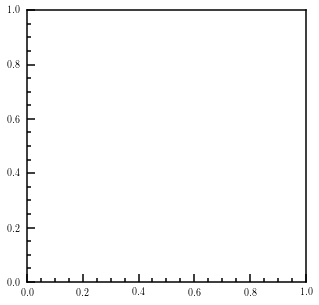

In [88]:
from astropy.io import fits
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

fileDir = '/Volumes/Project_Data/HSC_Subaru/Input/'
fileList = list(sorted(glob(fileDir+'*_i.fits')))
fig,ax = plt.subplots(1,1,figsize=(5,5))

count = 0
for fileName in fileList:
    num = min(fits.getdata(fileName).shape)
    if num<512: 
        print(num)
        count+=1
    
    #ax.imshow(np.log10(data),vmin=-3,vmax=1,cmap='Greys')
    
    


## Concatenate catalogues

In [5]:
import os,sys
import numpy as np

fileList = []
outCat = '/Users/cbottrell/Project/HSC-Subaru/Catalogues/HSC-TF_all_2019-07-16.txt'
if os.access(outCat,0): os.remove(outCat)

classIDs = ['stream','shell','non']
_fileName = '/Users/cbottrell/Project/HSC-Subaru/Catalogues/{}detection_hsctf_20190716.txt'
for classID in classIDs:
    fileList.append(_fileName.format(classID))
    

f = open(outCat,'a')
for fileName,classID in zip(fileList,classIDs):

    inpData = np.loadtxt(fileName,delimiter=',',dtype='str')
    targets = np.chararray(inpData.shape[0],itemsize=8,unicode=True)
    targets[:] = str(classID)
    targets = targets.reshape(-1,1)
    outData = np.append(inpData, targets, axis=1)
    np.savetxt(f, outData, delimiter=',',fmt='%s')
    
f.close()

(20010, 5)
